In [1]:
# Set up environment and imports
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
# Define constants
image_size = 128
batch_size = 32
k_folds = 5
epochs = 12
raw_dir = 'PlantVillage-Dataset/raw/color'
base_output = 'split_dataset'
test_ratio = 0.15
data_dir = 'split_dataset/train'

# Building custom CNN model

# -- Custom CNN model: data pre-processing phase --
# Split raw dataset into train/test folders (only "Tomato*" folders)
for split in ['train', 'test']:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

for class_name in os.listdir(raw_dir):
    if not class_name.startswith('Tomato'):
        continue  # Skip non-Tomato classes
    class_path = os.path.join(raw_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    train_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)

    for split, split_imgs in zip(['train', 'test'], [train_imgs, test_imgs]):
        split_class_dir = os.path.join(base_output, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copyfile(src, dst)

# Prepare DataFrame for training images
filepaths, labels = [], []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(class_path, fname))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Encode labels
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)


In [20]:
# -- Custom CNN model: model building and training phase --
# Set up K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
datagen = ImageDataGenerator(rescale=1./255)  # rescaling (normalisation)

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filepath'], df['encoded_label'])):
    print(f"\n--- Fold {fold+1} ---")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Training data generator
    train_gen = datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    # Validation data generator
    val_gen = datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Custom CNN model
    model = Sequential([
        Input(shape=(image_size, image_size, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)



--- Fold 1 ---
Found 12345 validated image filenames belonging to 10 classes.
Found 3087 validated image filenames belonging to 10 classes.
Epoch 1/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 62s 159ms/step - accuracy: 0.4841 - loss: 1.5299 - val_accuracy: 0.8131 - val_loss: 0.5673
Epoch 2/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - accuracy: 0.7594 - loss: 0.6815 - val_accuracy: 0.8623 - val_loss: 0.4287
Epoch 3/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - accuracy: 0.8257 - loss: 0.5062 - val_accuracy: 0.8850 - val_loss: 0.3796
Epoch 4/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - accuracy: 0.8481 - loss: 0.4422 - val_accuracy: 0.8882 - val_loss: 0.3763
Epoch 5/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - accuracy: 0.8776 - loss: 0.3382 - val_accuracy: 0.8931 - val_loss: 0.3462
Epoch 6/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 70s 180ms/step - accuracy: 0.8998 - loss: 0.3012 - val_accuracy: 0.9278 - val_loss: 0.2660
Epoch 7/12
386/386 ━━━━━━━━━━━━━━━━━━━━ 72s 186ms/step - accuracy: 0.9151

Found 15432 images belonging to 10 classes.
Found 2728 images belonging to 10 classes.
Epoch 1/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 76s 156ms/step - accuracy: 0.7791 - loss: 0.6653
Epoch 2/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 78s 161ms/step - accuracy: 0.8321 - loss: 0.4878
Epoch 3/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 89s 185ms/step - accuracy: 0.8638 - loss: 0.3925
Epoch 4/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 87s 179ms/step - accuracy: 0.8834 - loss: 0.3295
Epoch 5/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 89s 185ms/step - accuracy: 0.9030 - loss: 0.2828
Epoch 6/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 89s 185ms/step - accuracy: 0.9161 - loss: 0.2429
Epoch 7/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 100s 206ms/step - accuracy: 0.9246 - loss: 0.2178
Epoch 8/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 106s 220ms/step - accuracy: 0.9296 - loss: 0.2002
Epoch 9/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 97s 200ms/step - accuracy: 0.9420 - loss: 0.1635
Epoch 10/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 97s 202ms/step - accuracy: 0.9508 - loss: 0.1373
Epoch 11/12
483/483 

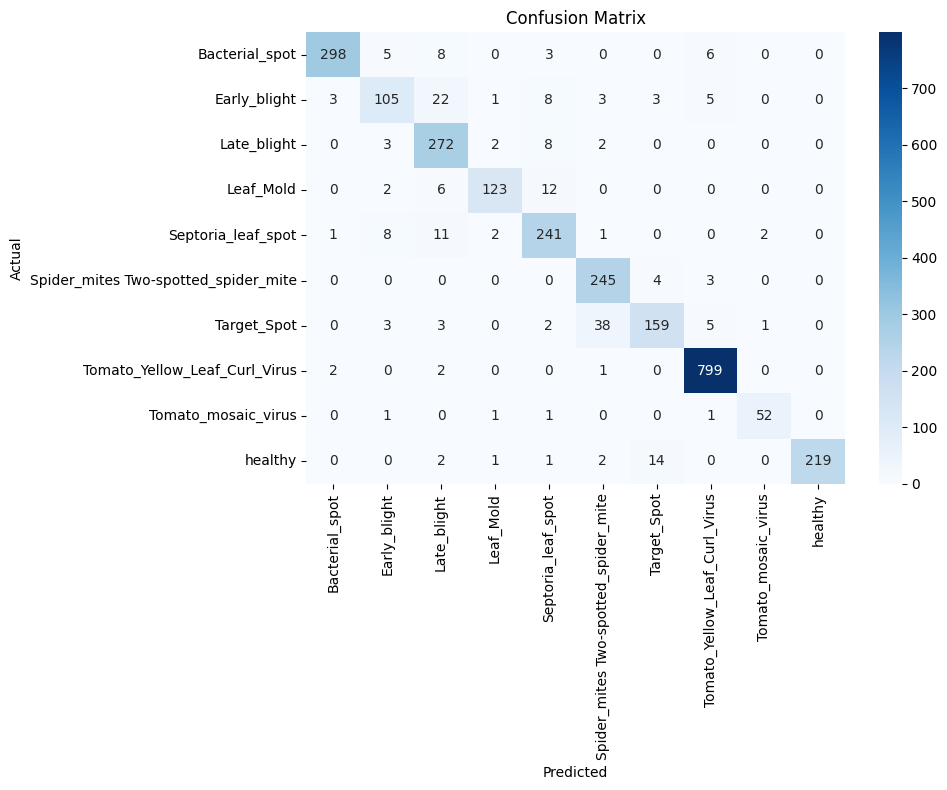

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.93      0.96       320
                        Early_blight       0.83      0.70      0.76       150
                         Late_blight       0.83      0.95      0.89       287
                           Leaf_Mold       0.95      0.86      0.90       143
                  Septoria_leaf_spot       0.87      0.91      0.89       266
Spider_mites Two-spotted_spider_mite       0.84      0.97      0.90       252
                         Target_Spot       0.88      0.75      0.81       211
       Tomato_Yellow_Leaf_Curl_Virus       0.98      0.99      0.98       804
                 Tomato_mosaic_virus       0.95      0.93      0.94        56
                             healthy       1.00      0.92      0.96       239

                            accuracy                           0.92      2728
                           macro avg       0.91      0.89     

In [10]:
# -- Custom CNN model: testing and evaluation phase --
# Re-train on full training set (excluding test set)
datagen = ImageDataGenerator(rescale=1./255)
full_train_gen = datagen.flow_from_directory(
    'split_dataset/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Prepare test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(full_train_gen, epochs=epochs)

# Predict labels on test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Get class labels (in correct order)
class_labels = [label.replace("Tomato___", "") for label in test_generator.class_indices.keys()]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert to DataFrame for nicer formatting
report_df = pd.DataFrame(report).transpose()

print(classification_report(y_true, y_pred, target_names=class_labels))

In [30]:
# Deploying SVM and RF based on refined data from pre-trained CNN model - ResNet50
# set up environment and imports
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [31]:
# Define constants
train_dir = 'split_dataset/train'
test_dir = 'split_dataset/test'
image_size = 224
batch_size = 32
n_splits = 5

# Collect image filepaths and labels from train and test directories
def collect_image_paths(data_dir):
    filepaths, labels = [], []
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(class_path, fname))
                labels.append(class_name)
    return filepaths, labels

train_paths, train_labels = collect_image_paths(train_dir)
test_paths, test_labels = collect_image_paths(test_dir)

# Create DataFrames
df_train = pd.DataFrame({'filepath': train_paths, 'label': train_labels})
df_test = pd.DataFrame({'filepath': test_paths, 'label': test_labels})

# Encode labels based on training set
df_train['encoded_label'], uniques = pd.factorize(df_train['label'])
df_test['encoded_label'] = df_test['label'].map({label: i for i, label in enumerate(uniques)})

# Clean class names
clean_class_names = [label.replace('Tomato___', '') for label in uniques]

# Load pre-trained ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(image_size, image_size, 3))

def extract_features(img_paths):
    features = []
    for path in tqdm(img_paths, desc="Extracting features"):
        img = load_img(path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        features.append(img_array)
    features = np.array(features)
    return resnet_model.predict(features, batch_size=batch_size)

# Extract features from pre-split train and test sets
X_train = extract_features(df_train['filepath'].values)
y_train = df_train['encoded_label'].values
X_test = extract_features(df_test['filepath'].values)
y_test = df_test['encoded_label'].values

# K-Fold cross-validation on training set
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Extracting features: 100%|██████████| 15432/15432 [00:13<00:00, 1114.65it/s]


483/483 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step


Extracting features: 100%|██████████| 2728/2728 [00:01<00:00, 1606.97it/s]


86/86 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step


In [42]:
# -- SVM model using extracted features from split dataset --
svm_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n--- Fold {fold + 1} ---")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    svm = SVC(C=5, probability=True)
    svm.fit(X_tr, y_tr)
    y_pred_svm = svm.predict(X_val)
    acc_svm = accuracy_score(y_val, y_pred_svm)
    svm_scores.append(acc_svm)
    print(f"SVM Accuracy: {acc_svm:.4f}")


--- Fold 1 ---
SVM Accuracy: 0.9832

--- Fold 2 ---
SVM Accuracy: 0.9835

--- Fold 3 ---
SVM Accuracy: 0.9864

--- Fold 4 ---
SVM Accuracy: 0.9857

--- Fold 5 ---
SVM Accuracy: 0.9870



SVM Test Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.99      1.00      1.00       320
                        Early_blight       0.95      0.92      0.93       150
                         Late_blight       0.98      0.98      0.98       287
                           Leaf_Mold       0.98      1.00      0.99       143
                  Septoria_leaf_spot       0.99      0.97      0.98       266
Spider_mites Two-spotted_spider_mite       0.98      0.99      0.98       252
                         Target_Spot       0.97      0.96      0.96       211
       Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00       804
                 Tomato_mosaic_virus       1.00      1.00      1.00        56
                             healthy       1.00      1.00      1.00       239

                            accuracy                           0.99      2728
                           macro avg       0

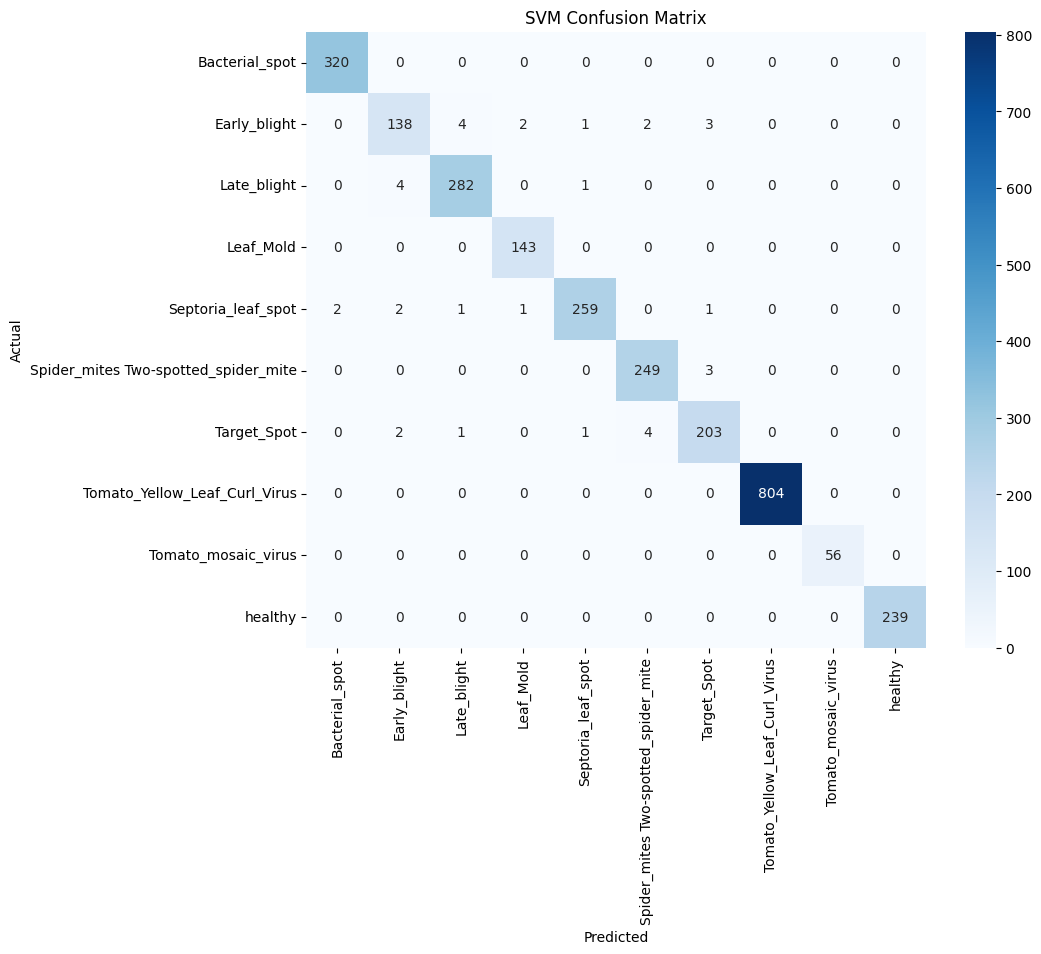

In [41]:
# SVM final evaluation on test set
final_svm = SVC(C=5, probability=True)
final_svm.fit(X_train, y_train)
y_test_pred_svm = final_svm.predict(X_test)

print("\nSVM Test Report:")
print(classification_report(y_test, y_test_pred_svm, target_names=clean_class_names))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_class_names, yticklabels=clean_class_names)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [43]:
# -- RF model using extracted features from split dataset --
rf_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n--- Fold {fold + 1} ---")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    rf.fit(X_tr, y_tr)
    y_pred_rf = rf.predict(X_val)
    acc_rf = accuracy_score(y_val, y_pred_rf)
    rf_scores.append(acc_rf)
    print(f"RF Accuracy: {acc_rf:.4f}")


--- Fold 1 ---
RF Accuracy: 0.9044

--- Fold 2 ---
RF Accuracy: 0.8882

--- Fold 3 ---
RF Accuracy: 0.9096

--- Fold 4 ---
RF Accuracy: 0.9135

--- Fold 5 ---
RF Accuracy: 0.9145



RF Test Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.90      0.98      0.94       320
                        Early_blight       0.97      0.50      0.66       150
                         Late_blight       0.89      0.95      0.92       287
                           Leaf_Mold       0.91      0.83      0.87       143
                  Septoria_leaf_spot       0.87      0.91      0.89       266
Spider_mites Two-spotted_spider_mite       0.82      0.94      0.88       252
                         Target_Spot       0.83      0.77      0.80       211
       Tomato_Yellow_Leaf_Curl_Virus       0.96      0.99      0.98       804
                 Tomato_mosaic_virus       0.97      0.64      0.77        56
                             healthy       0.98      0.98      0.98       239

                            accuracy                           0.91      2728
                           macro avg       0.

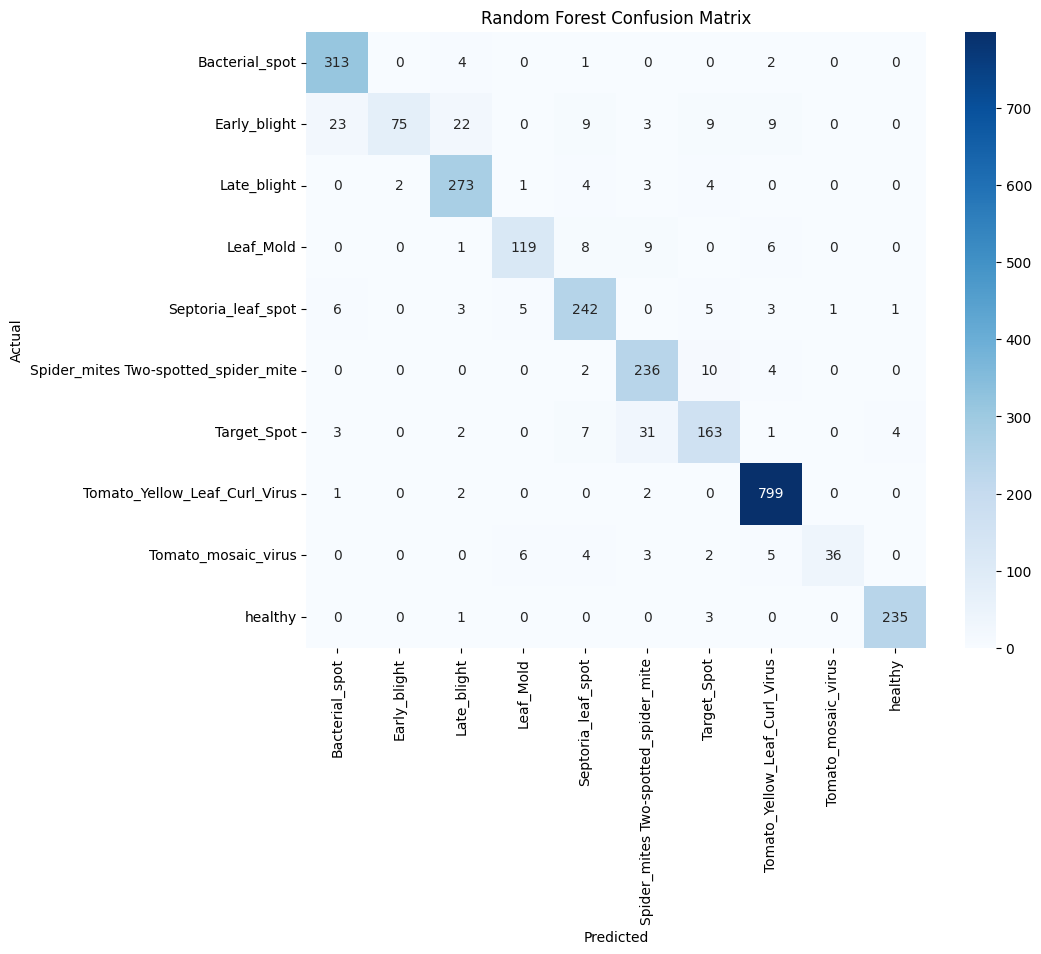

In [44]:
# RF final evaluation on test set
final_rf = RandomForestClassifier(n_estimators=500, random_state=42)
final_rf.fit(X_train, y_train)
y_test_pred_rf = final_rf.predict(X_test)

print("\nRF Test Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=clean_class_names))

# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_class_names, yticklabels=clean_class_names)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()